In [ ]:
!pip3 install tensorflow opencv-python matplotlib

In [ ]:
import tensorflow as tf
import os

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
import cv2
import imghdr

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
from PIL import Image

def remove_bad_images(s_dir, ext_list):
    bad_images = []
    bad_ext = []
    for folder in os.listdir(s_dir):
        folder_path = os.path.join(s_dir, folder)
        if os.path.isdir(folder_path):  # Ensure it's a directory
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                try:
                    with Image.open(file_path) as img:
                        if img.format.lower() not in ext_list:
                            bad_ext.append(file_path)
                            os.remove(file_path)  # Remove file with bad extension
                            print(f"Removed due to bad extension: {file_path}")
                        else:
                            img.verify()  # Verify it's an image
                except (IOError, SyntaxError) as e:
                    bad_images.append(file_path)
                    os.remove(file_path)  # Remove corrupted/bad file
                    print(f"Removed due to error {e}: {file_path}")

    return bad_images, bad_ext

# Your dataset directory and acceptable extensions
s_dir = '/content/drive/MyDrive/dataset'
ext_list = ['jpeg', 'png', 'bmp', 'gif']  # Acceptable image extensions

bad_file_list, bad_ext_list = remove_bad_images(s_dir, ext_list)

if bad_file_list or bad_ext_list:
    print("Removed bad files or files with bad extensions.")
else:
    print("No bad files found.")


No bad files found.


Found 5157 files belonging to 5 classes.


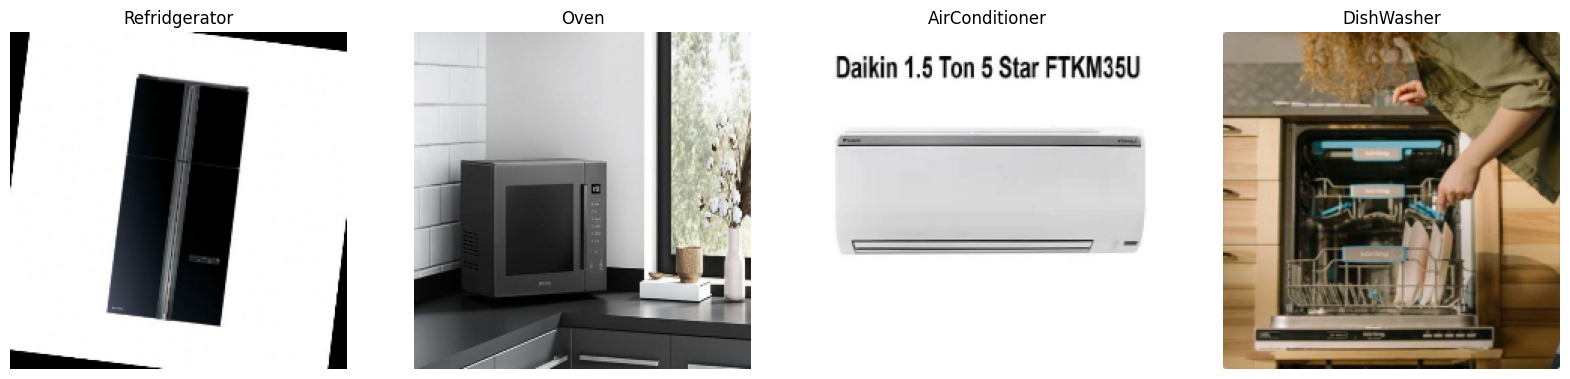

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

# Parameters
data_dir = '/content/drive/MyDrive/dataset'  # Make sure this path is correct
batch_size = 32
img_height = 224
img_width = 224
split_ratio = (0.7, 0.2, 0.1)

# Load the dataset and retrieve class names
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = data.class_names

# Function to scale images
def scale_images(image, label):
    return image / 255.0, label  # Scaled to [0, 1]

# Apply the scaling
data = data.map(scale_images)

# Determine dataset split sizes
total_batches = data.cardinality().numpy()
train_size = int(total_batches * split_ratio[0])
val_size = int(total_batches * split_ratio[1])

# Split the dataset
train_ds = data.take(train_size)
val_ds = data.skip(train_size).take(val_size)
test_ds = data.skip(train_size + val_size)

# Configure datasets for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Display a batch of images
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for images, labels in train_ds.take(1):
    for i in range(4):  # Display the first 4 images of the first batch
        ax[i].imshow(images[i].numpy())
        ax[i].title.set_text(class_names[labels[i]])
        ax[i].axis("off")
plt.show()


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd


In [ ]:
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base model
base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),  # Lower learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])




In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
113/113 [==============================] - 22s 183ms/step - loss: 1.0384 - accuracy: 0.6662 - val_loss: 0.4504 - val_accuracy: 0.8604
Epoch 2/10
113/113 [==============================] - 20s 173ms/step - loss: 0.5176 - accuracy: 0.8095 - val_loss: 0.3648 - val_accuracy: 0.8789
Epoch 3/10
113/113 [==============================] - 19s 168ms/step - loss: 0.3898 - accuracy: 0.8662 - val_loss: 0.3822 - val_accuracy: 0.8613
Epoch 4/10
113/113 [==============================] - 19s 169ms/step - loss: 0.3040 - accuracy: 0.8902 - val_loss: 0.3375 - val_accuracy: 0.8867
Epoch 5/10
113/113 [==============================] - 19s 173ms/step - loss: 0.2576 - accuracy: 0.9121 - val_loss: 0.2916 - val_accuracy: 0.9043
Epoch 6/10
113/113 [==============================] - 19s 173ms/step - loss: 0.2280 - accuracy: 0.9154 - val_loss: 0.3099 - val_accuracy: 0.8936
Epoch 7/10
113/113 [==============================] - 19s 171ms/step - loss: 0.1997 - accuracy: 0.9256 - val_loss: 0.3381 - val_ac

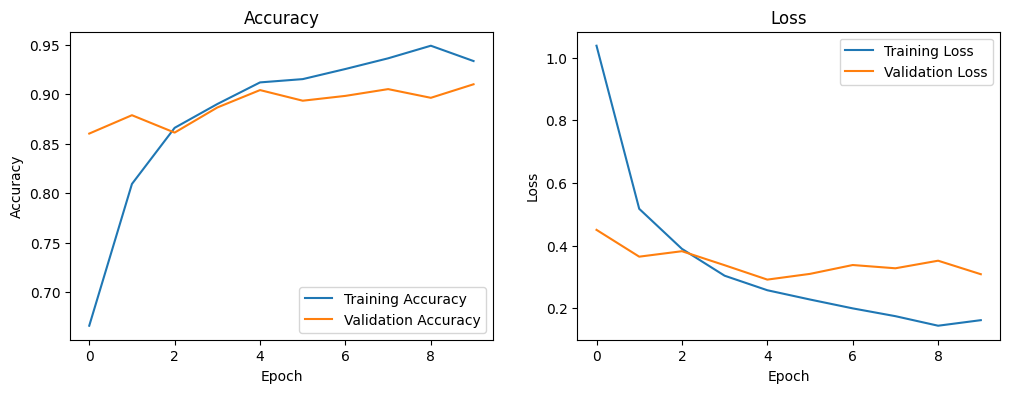

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
test_images, test_labels = next(iter(test_ds.unbatch().batch(len(test_ds))))
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.array(test_labels)

accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='macro')
recall = recall_score(true_classes, predicted_classes, average='macro')
f1 = f1_score(true_classes, predicted_classes, average='macro')


1/1 [==============================] - 0s 146ms/step


In [ ]:
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Value': [accuracy, precision, recall, f1]
}).set_index('Metric')

print(metrics_df)


              Value
Metric             
Accuracy   0.941176
Precision  0.900000
Recall     0.966667
F1 Score   0.915152


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

image_path = '/content/drive/MyDrive/8.jpg'

img = load_img(image_path, target_size=(224, 224))

img_array = img_to_array(img)

img_batch = np.expand_dims(img_array, axis=0)

img_preprocessed = preprocess_input(img_batch)

predictions = model.predict(img_preprocessed)

predicted_class = np.argmax(predictions, axis=1)[0]

predicted_class_name = class_names[predicted_class]

print(f"Predicted class: {predicted_class_name}")



1/1 [==============================] - 0s 18ms/step
Predicted class: AirConditioner


In [ ]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>